# Test 2 - Colorization of RGB images

In this notebook, I am exploring the colorization of images depeding on existing incomplete RGB data.
In particluar, the idea is to infer the B channel from existing R and G channels.

The dataset in use is [GTSRB](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/).
This dataset is not specifically made for this task, but it was easy to obtain and thus good to start with.

In [81]:
import os
import numpy as np
import skimage

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

## Load data
Currently only loading class 0.

In [56]:
DATA_DIR = '../../data/gtsrb-german-traffic-sign/Train/0'
DIMS = (100, 100)

color, gray = [], []
for file in os.listdir(DATA_DIR):
    img = imread(os.path.join(DATA_DIR, file))
    img = resize(img, DIMS)
    color.append(img)
    
color = np.array(color)
r = color[..., 0]
g = color[..., 1]
b = color[..., 2]
gray = rgb2gray(color)[..., None]

print(color.shape)
print(r.shape)
print(gray.shape)

(210, 100, 100, 3)
(210, 100, 100)
(210, 100, 100, 1)


## Display example image

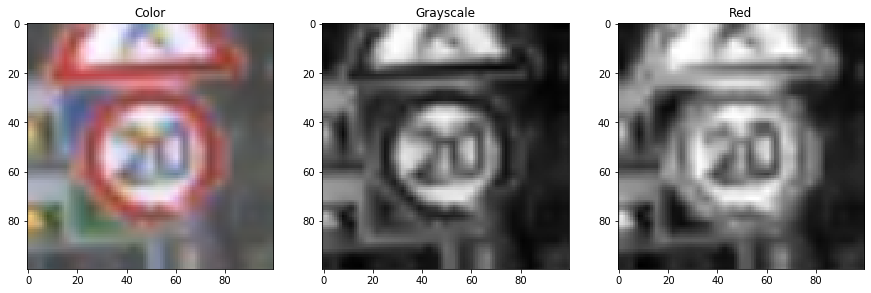

In [57]:
fig = plt.figure()

ax1 = fig.add_subplot(131)
ax1.imshow(color[0, ...])
ax1.title.set_text('Color')

ax2 = fig.add_subplot(132)
ax2.imshow(gray[0, ..., 0], cmap='gray')
ax2.title.set_text('Grayscale')

ax3 = fig.add_subplot(133)
ax3.imshow(r[0, ...], cmap='gray')
ax3.title.set_text('Red')

## Prepare data for model
* Normalize y to range [-1, 1] to match output function
* Split into train and test data

In [105]:
test_size = 0.1

# X = r[..., None]
# y = np.stack([g * 2 - 1, b * 2 - 1], axis=3)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

color_train, color_test = train_test_split(color, test_size=test_size)

X_train = color_train[..., :2]
X_test = color_test[..., :2]

y_train = color_train[..., 2] * 2 - 1
y_test = color_test[..., 2,] * 2 - 1



print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

(189, 100, 100) (21, 100, 100)
(189, 100, 100, 2) (21, 100, 100, 2)


## Create and train model

In [108]:
model = Sequential()

model.add(InputLayer(input_shape=(None, None, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))

# Finish model
model.compile(optimizer='rmsprop', loss='mse')

In [109]:
# use gray, not X
model.fit(x=X_train, y=y_train, batch_size=1, epochs=3, verbose=1)

Train on 189 samples
Epoch 1/3
189/189 [==============================] - 14s 74ms/sample - loss: 0.0815
Epoch 2/3
189/189 [==============================] - 13s 71ms/sample - loss: 0.0286
Epoch 3/3
189/189 [==============================] - 13s 67ms/sample - loss: 0.0233


## Display example output

(21, 100, 100, 1)


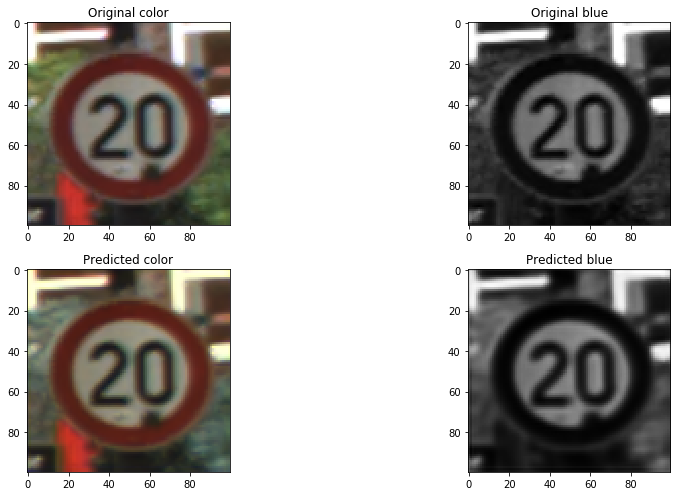

In [118]:
index = 10

output = model.predict(X_test)
print(output.shape)
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.imshow(color_test[index])
ax1.title.set_text('Original color')

ax2 = fig.add_subplot(222)
ax2.imshow(y_test[index], cmap='gray')
ax2.title.set_text('Original blue')

ax3 = fig.add_subplot(223)
ax3.imshow(np.dstack([X_test[index, ..., 0], X_test[index, ..., 1], (output[index, ..., 0] + 1) / 2]), cmap='gray')
ax3.title.set_text('Predicted color')

ax4 = fig.add_subplot(224)
ax4.imshow((output[index, ..., 0] + 1) / 2, cmap='gray')
ax4.title.set_text('Predicted blue')

fig.tight_layout()
fig.show()